In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import csv
import scipy.stats as stats
from tensorboard.plugins.hparams import api as hp
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)

import seaborn as sns
from Data import Data
from datetime import datetime
import feature_finder_keiko as ff


/home/mathsys2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Could not import rpy package
Could not import r-package RCIT


In [2]:
tau = 6

n_components_sst = 98

link_caus = np.load("./link_rotated_station/best_link_1976_2010_{}.npy".format(tau))
link_corr = np.load("./link_rotated_station/best_link_corr_1976_2010_{}.npy".format(tau))

In [3]:
train_start = 1976
validation_end = 2010

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)
#data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated(file_name, "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [4]:
data_sst = np.load("data_sst.npy")
V = np.load("V.npy")
ts = np.load("ts.npy")
avg = np.load("avg.npy")
std = np.load("std.npy")
data_sst_test = np.load("data_sst_test.npy")

In [5]:
df_sst = pd.read_csv("df_sst.csv")

In [6]:
test_start = 2011
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
#data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

In [7]:
del df_sst["Unnamed: 0"]

In [8]:
#Hybrid

for i in range(len(link_corr)):
    if not np.array(link_corr == list(link_corr[i])).all(axis=1).all():
        link_caus = np.concatenate((link_caus, np.reshape(link_corr[i,:],(1,2))))
link_hybrid = link_caus
link_caus = np.load("./link_rotated_station/best_link_1976_2010_{}.npy".format(tau))

l, b, m = ff.forward_feature_V(count, data_sst, link_hybrid, V, tau)

link = l

start_lag = tau
end_lag = tau + 12

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [25]:
#l for hybrid or link_corr or link_caus
link = l

start_lag = tau
end_lag = tau+12

df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

In [26]:
start_lag = tau
end_lag = tau + 12

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

In [21]:
!rm -rf ./logs/

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([8,16,32])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([8,16,32]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([8,16,32])) 
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1,0.2))
HP_LR = hp.HParam('learning_rate', hp.RealInterval(.001,.01))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    opt = keras.optimizers.RMSprop(learning_rate=hparams[HP_LR])

    #optimizer=hparams[HP_OPTIMIZER]
    model.compile(optimizer=opt,
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
                for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                    for learning_rate in (HP_LR.domain.min_value, HP_LR.domain.max_value):
                    #for optimizer in HP_OPTIMIZER.domain.values:
                        hparams = {
                            HP_NUM_UNITS1: num_units1,
                            HP_NUM_UNITS2: num_units2,
                            HP_NUM_UNITS3: num_units3,
                            HP_DROPOUT: dropout_rate,
                            HP_L2: l2,
                            HP_LR: learning_rate
                            #HP_OPTIMIZER: optimizer
                        }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                        if (~np.isnan(rmse)) and (rmse < min_rmse): 
                            best_hparams = current_hparams
                            min_rmse = rmse
                            print("mis_rmse {}".format(min_rmse))
                        session_num += 1

--- Starting trial: run-0
{'num_units 1': 8, 'num_units 2': 8, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 274802.9425 - RootMeanSquaredError: 524.2165
mis_rmse 524.2164916992188
--- Starting trial: run-1
{'num_units 1': 8, 'num_units 2': 8, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 1288869.3415 - RootMeanSquaredError: 1135.2838
--- Starting trial: run-2
{'num_units 1': 8, 'num_units 2': 8, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 155314.8758 - RootMeanSquaredError: 394.0997
mis_rmse 394.0997314453125
--- Starting trial: run-3
{'num_units 1': 8, 'num_units 2': 8, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.01}
42/42 [==============================] -

42/42 [==============================] - 0s 2ms/sample - loss: 69885024.5714 - RootMeanSquaredError: 8359.7266
--- Starting trial: run-32
{'num_units 1': 8, 'num_units 2': 16, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 593076.6049 - RootMeanSquaredError: 770.1146
--- Starting trial: run-33
{'num_units 1': 8, 'num_units 2': 16, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 5637213.4531 - RootMeanSquaredError: 2374.2817
--- Starting trial: run-34
{'num_units 1': 8, 'num_units 2': 16, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 949533.0406 - RootMeanSquaredError: 974.4396
--- Starting trial: run-35
{'num_units 1': 8, 'num_units 2': 16, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 

42/42 [==============================] - 0s 2ms/sample - loss: 11967366.1285 - RootMeanSquaredError: 3459.3879
--- Starting trial: run-64
{'num_units 1': 8, 'num_units 2': 32, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 1889165.0089 - RootMeanSquaredError: 1374.4690
--- Starting trial: run-65
{'num_units 1': 8, 'num_units 2': 32, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 4291890.0476 - RootMeanSquaredError: 2071.6877
--- Starting trial: run-66
{'num_units 1': 8, 'num_units 2': 32, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 142564.6719 - RootMeanSquaredError: 377.5765
--- Starting trial: run-67
{'num_units 1': 8, 'num_units 2': 32, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer'

42/42 [==============================] - 0s 2ms/sample - loss: 4389414.7560 - RootMeanSquaredError: 2095.0928
--- Starting trial: run-96
{'num_units 1': 16, 'num_units 2': 16, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 721945.5089 - RootMeanSquaredError: 849.6737
--- Starting trial: run-97
{'num_units 1': 16, 'num_units 2': 16, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 5292101.6825 - RootMeanSquaredError: 2300.4568
--- Starting trial: run-98
{'num_units 1': 16, 'num_units 2': 16, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 470843.1539 - RootMeanSquaredError: 686.1797
--- Starting trial: run-99
{'num_units 1': 16, 'num_units 2': 16, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0

42/42 [==============================] - 0s 2ms/sample - loss: 22572094.0145 - RootMeanSquaredError: 4751.0098
--- Starting trial: run-128
{'num_units 1': 16, 'num_units 2': 32, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 2161736.7638 - RootMeanSquaredError: 1470.2845
--- Starting trial: run-129
{'num_units 1': 16, 'num_units 2': 32, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 9992500.5774 - RootMeanSquaredError: 3161.0918
--- Starting trial: run-130
{'num_units 1': 16, 'num_units 2': 32, 'num_units 3': 16, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 494234.7076 - RootMeanSquaredError: 703.0176
--- Starting trial: run-131
{'num_units 1': 16, 'num_units 2': 32, 'num_units 3': 16, 'dropout': 0.1, 'l2 regu

42/42 [==============================] - 0s 2ms/sample - loss: 16851392.8452 - RootMeanSquaredError: 4105.0444
--- Starting trial: run-160
{'num_units 1': 32, 'num_units 2': 8, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 543863.0087 - RootMeanSquaredError: 737.4706
--- Starting trial: run-161
{'num_units 1': 32, 'num_units 2': 8, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 9128345.6667 - RootMeanSquaredError: 3021.3152
--- Starting trial: run-162
{'num_units 1': 32, 'num_units 2': 8, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 679064.7072 - RootMeanSquaredError: 824.0534
--- Starting trial: run-163
{'num_units 1': 32, 'num_units 2': 8, 'num_units 3': 32, 'dropout': 0.1, 'l2 regularize

42/42 [==============================] - 0s 2ms/sample - loss: 6612778.3304 - RootMeanSquaredError: 2571.5315
--- Starting trial: run-192
{'num_units 1': 32, 'num_units 2': 32, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 592764.9632 - RootMeanSquaredError: 769.9122
--- Starting trial: run-193
{'num_units 1': 32, 'num_units 2': 32, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'learning_rate': 0.01}
42/42 [==============================] - 0s 2ms/sample - loss: 12861319.3519 - RootMeanSquaredError: 3586.2683
--- Starting trial: run-194
{'num_units 1': 32, 'num_units 2': 32, 'num_units 3': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'learning_rate': 0.001}
42/42 [==============================] - 0s 2ms/sample - loss: 5080049.1548 - RootMeanSquaredError: 2253.8962
--- Starting trial: run-195
{'num_units 1': 32, 'num_units 2': 32, 'num_units 3': 8, 'dropout': 0.1, 'l2 regulari

In [28]:
best_hparams

{HParam(name='num_units 1', domain=Discrete([8, 16, 32]), display_name=None, description=None): 8,
 HParam(name='num_units 2', domain=Discrete([8, 16, 32]), display_name=None, description=None): 32,
 HParam(name='num_units 3', domain=Discrete([8, 16, 32]), display_name=None, description=None): 32,
 HParam(name='dropout', domain=RealInterval(0.1, 0.2), display_name=None, description=None): 0.2,
 HParam(name='l2 regularizer', domain=RealInterval(0.001, 0.01), display_name=None, description=None): 0.001,
 HParam(name='learning_rate', domain=RealInterval(0.001, 0.01), display_name=None, description=None): 0.001}

In [29]:
min_rmse

136.39232

In [118]:
!kill 30985

In [119]:
%tensorboard --logdir logs/hparam_tuning

In [18]:
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
    ])
    
    
    opt = keras.optimizers.RMSprop(learning_rate=1e-38)
    model.compile(optimizer=opt,
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=500, verbose=False)

In [16]:
_, rmse = model.evaluate(x_test, y_test)

42/42 [==============================] - 0s 5ms/sample - loss: 635.8528 - RootMeanSquaredError: 25.1656


In [17]:
rmse

25.165632

In [71]:
y_pred = model.predict(x_test)

In [72]:
mean_squared_error(y_pred, y_test)

13613.65902582544

In [61]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
layers.Dense(8,  activation=tf.nn.tanh),
layers.Dropout(0.1),
layers.Dense(8,  activation=tf.nn.tanh),
layers.Dense(1)
])


model.compile(optimizer="RMSprop",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

model.fit(x_train, y_train, epochs=100, verbose=False) 

In [57]:
y_pred = model.predict(x_test)

In [53]:
y_pred

array([[1.4895995e+00],
       [8.5060892e+00],
       [1.9260878e+01],
       [2.4538725e+01],
       [3.6993462e+01],
       [2.6789055e+01],
       [2.9841509e+01],
       [1.7474697e+01],
       [1.0664298e+03],
       [8.5314665e+00],
       [1.0022528e+01],
       [1.2978404e+01],
       [5.3724070e+00],
       [5.5510498e+02],
       [6.8393726e+02],
       [2.2650869e+01],
       [2.2496393e+01],
       [2.8610126e+01],
       [3.4158810e+02],
       [1.9621093e+03],
       [1.2300923e+01],
       [2.2863768e+01],
       [1.5900949e+01],
       [8.5835814e-02],
       [1.1071695e+01],
       [1.5360101e+01],
       [1.3849007e+01],
       [1.2183182e+01],
       [8.6951953e+02],
       [1.2063634e+01],
       [1.2595251e+01],
       [1.3637677e+01],
       [2.8857388e+02],
       [1.5576586e+03],
       [1.1292948e+01],
       [1.1431256e+01],
       [2.3997393e+01],
       [1.6098343e+01],
       [6.4217529e+01],
       [1.7023300e+01],
       [2.0215223e+01],
       [6.156706

In [54]:
y_test

18     1
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     1
27    14
28    33
29    18
30    16
31     7
32     4
33    13
34     1
35     0
36     1
37     0
38     0
39     0
40     3
41     0
42     0
43    11
44    10
45    12
46    11
47    19
48    16
49    19
50    22
51    22
52    13
53    12
54    11
55    26
56    39
57    61
58    87
59    82
Name: drought, dtype: int64

821671.6460362317

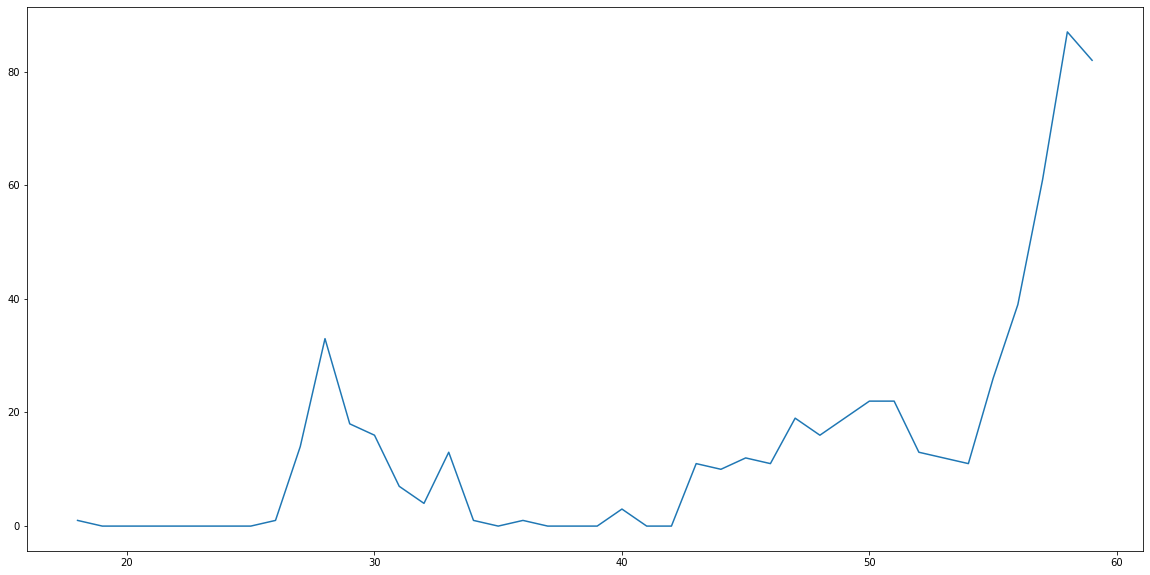

In [41]:
plt.plot(y_test)

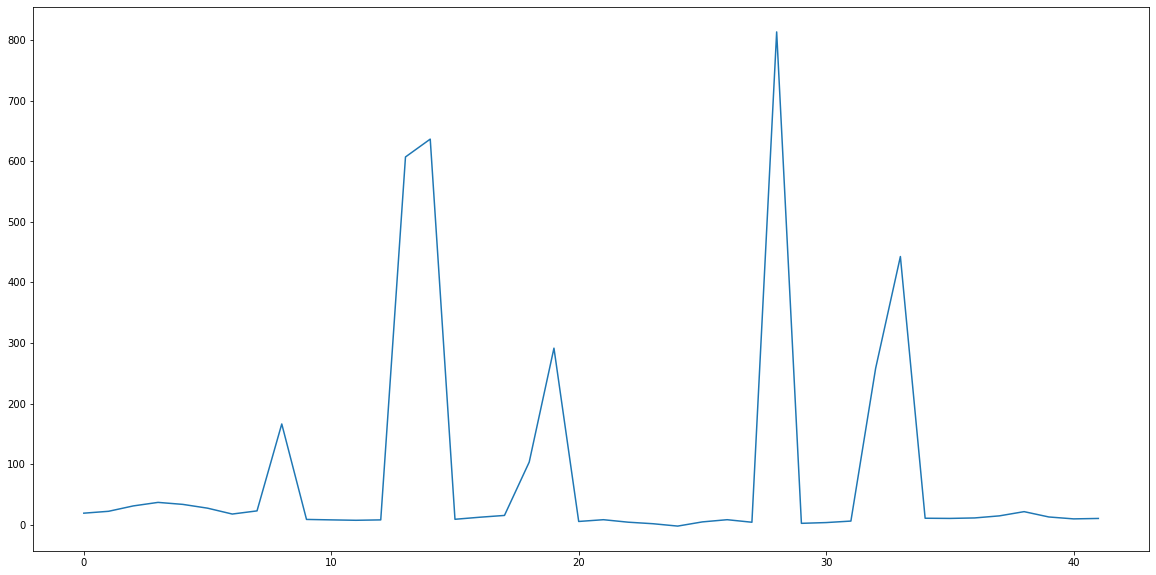

In [42]:
plt.plot(y_pred)